# Data Exploration: **Do People with Different Ideologies Speak Differently?**


## **Mounting the Google Drive**

It is possible to mount your Google Drive to Colab if you need additional storage or if you need to use files from it. To do that run (click on play button or use keyboard shortcut 'Command/Ctrl+Enter') the following code cell:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1.   After running the cell, URL will appear.

2.   Following this URL, you will be redirected to the page where you need to choose Google Drive account to mount to.

3.   You will further be asked to give Google Drive Stream a permission to access the chosen Google account

4.   After granting the access, authorization code will be given to you

5.   Copy the authorization code into the dedicated textbox in Colab under '*Enter your authorization code:*' writing

After copying the authorization code, you should get the message saying '*Mounted at /content/gdrive*'

Path to the files from the mounted Drive will then be '/content/drive/MyDrive/'. By opening the Files tab (left sidebar, folder icon) you should also be able to see the accessible files.

## **Required Libraries**

In [2]:
!pip install pandas==1.3.1
!pip install qwikidata
!pip install empath
!pip install pyLDAvis
!pip install nltk gensim spacy
!python -m spacy download en

     |████████████████████████████████| 11.5 MB 3.7 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.1 which is incompatible.


     |████████████████████████████████| 57 kB 2.1 MB/s 
  Created wheel for empath: filename=empath-0.89-py3-none-any.whl size=57821 sha256=e9da920f948a661f6eed29653e1a866b0404e3e42c87668124edfb2513331f61
  Stored in directory: /root/.cache/pip/wheels/2b/78/a8/37d4505eeae79807f4b5565a193f7cfcee892137ad37591029
Successfully built empath
     |████████████████████████████████| 1.7 MB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.7 MB 37.0 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=72917e1bf0ecfda80d9216d79a222ec02aa82ea59cb709bbd2c077d805cc7f70
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uni

     |████████████████████████████████| 12.0 MB 4.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [1]:
import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import bz2
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy.stats as stats
from qwikidata.linked_data_interface import get_entity_dict_from_api

#NLP libraries
from empath import Empath
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models

seed = 42
random.seed(seed)
np.random.seed(seed)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


## **Load and Merge Preprocessed Data Into Single Dataframe**
The first step is to merge together all different parquet files from different year in a single dataframe. It will allow to work easily on it, and perform the entire analysis.<br>
After an initial analysis on the preprocessed data, it was noticed that further filtering operations were needed. All were performed in the same function loading the data, and are the following:
- drop quotations of politicians who switched parties during the time frame (about 14,11%). Considering them would have meant integrating also the time frame related to each political party "phase" (not necessary for our analysis);
- drop quotation with an unordered probability list (0,00092%);
- remove entries with speaker maximum probability < 0.6, in order to reduce uncertainty. This value could be changed in the future, depending on the analysis results.

In [ ]:
file_path_2020 = '/content/drive/MyDrive/Quotebank_Repub_Dem/new-quotes-2020-repub-dem.parquet'
file_path_2019 = '/content/drive/MyDrive/Quotebank_Repub_Dem/new-quotes-2019-repub-dem.parquet'
file_path_2018 = '/content/drive/MyDrive/Quotebank_Repub_Dem/new-quotes-2018-repub-dem.parquet'
file_path_2017 = '/content/drive/MyDrive/Quotebank_Repub_Dem/new-quotes-2017-repub-dem.parquet'
file_path_2016 = '/content/drive/MyDrive/Quotebank_Repub_Dem/new-quotes-2016-repub-dem.parquet'
file_path_2015 = '/content/drive/MyDrive/Quotebank_Repub_Dem/new-quotes-2015-repub-dem.parquet'
file_path_final = '/content/drive/MyDrive/Quotebank_Repub_Dem/new-quotes-final-repub-dem.parquet'

prob_threshold = 0.6

# load preprocessed data and merge them in a single dataframe
def load_and_merge():
  # load
  df_20 = pd.read_parquet(file_path_2020)
  df_19 = pd.read_parquet(file_path_2019)
  df_18 = pd.read_parquet(file_path_2018)
  df_17 = pd.read_parquet(file_path_2017)
  df_16 = pd.read_parquet(file_path_2016)
  df_15 = pd.read_parquet(file_path_2015)

  # merge into single dataframe
  df = pd.concat([df_20, df_19, df_18, df_17, df_16, df_15], ignore_index=True)

  # delete unused variables for garbage collector
  del df_20
  del df_19
  del df_18
  del df_17
  del df_16
  del df_15

  # remove entries with more then 1 party
  df = df[df["party"].apply(len) == 1]

  # remove entries where the speaker with maximum probability is not the first in the list
  max_prob_speaker = df['probas'].apply(lambda x: x[0][0])
  df['max_prob_speaker'] = max_prob_speaker
  df = df[df["speaker"] == df['max_prob_speaker']]

  # remove entries with best speaker probability less the 0.6
  max_probas = df['probas'].apply(lambda x: x[0][1])
  df['max_probas'] = max_probas.astype(float)
  df = df[df["max_probas"] > prob_threshold]

  # remove added columns
  #df = df.drop(["max_probas", "max_prob_speaker"], axis=1)

  return df

# Load and merge into a single dataframe
df = load_and_merge()
df

,quoteID,quotation,speaker,qids,probas,gender,occupation,party,max_prob_speaker,max_probas
0,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,Q367796,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[Q6581072],[Q82955],[Q29468],Sue Myrick,0.8867
9,2020-01-26-000499,a few of the candidates who will do better in ...,Dave Loebsack,Q771586,"[[Dave Loebsack, 0.9011], [None, 0.0949], [Joe...",[Q6581097],"[Q82955, Q1622272, Q1238570]",[Q29552],Dave Loebsack,0.9011
10,2020-01-26-040663,"The generational thing is important, quite hon...",Dave Loebsack,Q771586,"[[Dave Loebsack, 0.7419], [None, 0.2133], [Pet...",[Q6581097],"[Q82955, Q1622272, Q1238570]",[Q29552],Dave Loebsack,0.7419
12,2020-01-09-060095,"No, are you kidding? The way that this place l...",Debbie Lesko,Q16731415,"[[Debbie Lesko, 0.7444], [None, 0.2323], [Pres...",[Q6581072],[Q82955],[Q29468],Debbie Lesko,0.7444
14,2020-01-30-029113,I actually believe that we do need to change t...,Julián Castro,Q970720,"[[Julián Castro, 0.9028], [None, 0.0972]]",[Q6581097],"[Q82955, Q40348]",[Q29552],Julián Castro,0.9028
...,...,...,...,...,...,...,...,...,...,...
7681437,2015-10-07-024138,For them to come back sends a message that we'...,Steve Tumlin,Q7614169,"[[Steve Tumlin, 0.7326], [None, 0.2674]]",[Q6581097],[Q82955],[Q29468],Steve Tumlin,0.7326
7681438,2015-03-14-008824,"From the beginning, the whole issue has had hi...",Jamie Raskin,Q640835,"[[Jamie Raskin, 0.661], [None, 0.2843], [Jim O...",[Q6581097],"[Q82955, Q1622272]",[Q29552],Jamie Raskin,0.6610
7681439,2015-10-17-014629,He [ Hansen ] was writing that grant while he ...,Teresa Fedor,Q7702134,"[[Teresa Fedor, 0.7461], [None, 0.1156], [Rich...",[Q6581072],[Q82955],[Q29552],Teresa Fedor,0.7461
7681440,2015-06-19-015086,help stop profitable multinationals from engag...,Carl Levin,Q444652,"[[Carl Levin, 0.8162], [None, 0.1838]]",[Q6581097],"[Q82955, Q40348]",[Q29552],Carl Levin,0.8162


Text(0, 0.5, 'Number of Speakers')

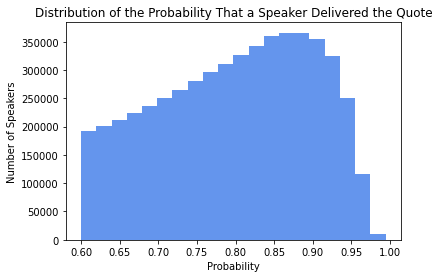

In [ ]:
# Plot the distribution of the speakers' probabilities
df['max_probas'] = df['max_probas'].astype(float) # transform the string values into float
ax = df['max_probas'].plot.hist(bins=20, color = 'cornflowerblue')
ax.set_title('Distribution of the Probability That a Speaker Delivered the Quote')
ax.set_xlabel("Probability")
ax.set_ylabel("Number of Speakers")


In [ ]:
# Add number of quotations per qid to dataframe (Caution: this column is already aggregated)
df['quotationCounts'] = df.groupby(['qids'])['quoteID'].transform("count")

In [ ]:
republican_qid = 'Q29468'
democrats_qid = 'Q29552'
republicans_df = df.loc[df['party'].str[0] == republican_qid] #People from the republican party
democrats_df = df.loc[df['party'].str[0] == democrats_qid] #People from the democratic party

In [ ]:
# Number of of quotations per qid for republicans
n_quotes_per_qid_repub = republicans_df.groupby(['qids'])['quotationCounts'].mean()
n_quotes_per_qid_repub.describe()

count     7927.000000
mean       318.935789
std       1496.761344
min          1.000000
25%         11.000000
50%         48.000000
75%        177.000000
max      35694.000000
Name: quotationCounts, dtype: float64

In [ ]:
# Number of of quotations per qid for democrats
n_quotes_per_qid_demo = democrats_df.groupby(['qids'])['quotationCounts'].mean()
n_quotes_per_qid_demo.describe()

count      7899.000000
mean        349.190657
std        1991.496176
min           1.000000
25%          10.000000
50%          49.000000
75%         193.000000
max      118912.000000
Name: quotationCounts, dtype: float64

The number of speakers of the Republican party (7927) and the number of speakers of the Democratic party (7899) is almost the same. 

Text(0, 0.5, 'Number of Speakers')

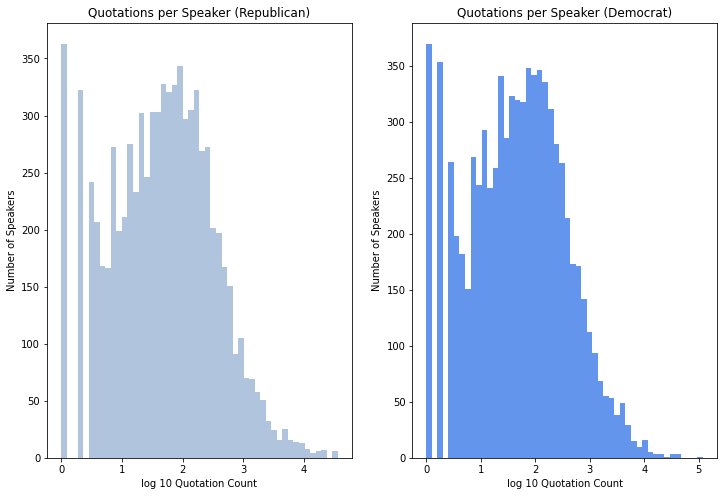

In [ ]:
# Visualize the number of quotations per speaker grouped by Democrats and Republicans
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

subplot = axes[0];
subplot.hist(np.log10(n_quotes_per_qid_repub), bins = 50, color = 'lightsteelblue')
subplot.set_title('Quotations per Speaker (Republican)')
subplot.set_xlabel('log 10 Quotation Count')
subplot.set_ylabel('Number of Speakers')


subplot = axes[1];
subplot.hist(np.log10(n_quotes_per_qid_demo), bins = 50, color = 'cornflowerblue')
subplot.set_title('Quotations per Speaker (Democrat)')
subplot.set_xlabel('log 10 Quotation Count')
subplot.set_ylabel('Number of Speakers')


In [ ]:
# Top speakers of the Democratic Party
n_quotes_per_qid_demo.sort_values(ascending=False)

qids
Q76          118912
Q6279         42902
Q170581       40580
Q11673        37313
Q434706       36874
              ...  
Q6134388          1
Q6133705          1
Q6133121          1
Q6132468          1
Q16187065         1
Name: quotationCounts, Length: 7899, dtype: int64

In [ ]:
# Top speakers of the Republican Party
n_quotes_per_qid_repub.sort_values(ascending=False)

qids
Q473239      35694
Q24313       35650
Q22212       35365
Q2036942     34682
Q324546      32509
             ...  
Q363976          1
Q363972          1
Q34911531        1
Q3258787         1
Q1017083         1
Name: quotationCounts, Length: 7927, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


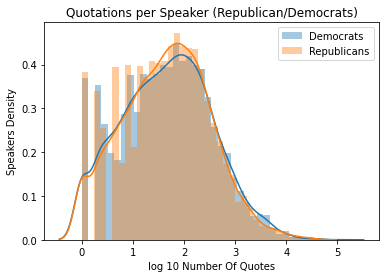

In [ ]:
ax = sns.distplot(np.log10(n_quotes_per_qid_demo), hist=True, label='Democrats');
ax = sns.distplot(np.log10(n_quotes_per_qid_repub), hist=True, label='Republicans')
ax.set(title='Quotations per Speaker (Republican/Democrats)',xlabel='log 10 Number Of Quotes', ylabel='Speakers Density')
plt.legend()
plt.show()

## **Distribution of Male/Female Speaker within Each Political Party**

In [ ]:
female_qid = 'Q6581072'
male_qid = 'Q6581097'
# Let's start with the Republicans
repub_females = republicans_df[republicans_df['gender'].str[0] == female_qid ]
repub_females.describe()

NameError: ignored

In [ ]:
repub_males = republicans_df[republicans_df['gender'].str[0] == male_qid ]
repub_males.describe()

NameError: ignored

In [ ]:
female_male_quotes_fraction_repub = len(repub_females)/len(republicans_df)*100
print(f'only {female_male_quotes_fraction_repub:.2f} % of the republican quotes are delivered from women')

In [ ]:
# Let's do the same analysis with the democrats
democrats_females = democrats_df[democrats_df['gender'].str[0] == female_qid ]
democrats_females

In [ ]:
democrats_males = democrats_df[democrats_df['gender'].str[0] == male_qid ]
democrats_males

In [ ]:
female_male_quotes_fraction_demo = len(democrats_females)/len(democrats_df)*100
print(f' {female_male_quotes_fraction_demo:.2f} % of the democrats quotes are delivered from women')

In [ ]:
n_quotes_female_per_qid_demo = democrats_females.groupby(['qids'])['quotationCounts'].mean()
n_quotes_female_per_qid_repub = repub_females.groupby(['qids'])['quotationCounts'].mean()
n_quotes_male_per_qid_demo = democrats_males.groupby(['qids'])['quotationCounts'].mean()
n_quotes_male_per_qid_repub = repub_males.groupby(['qids'])['quotationCounts'].mean()

In [ ]:
n_quotes_female_per_qid_demo.describe()

In [ ]:
n_quotes_female_per_qid_repub.describe()

In [ ]:
# Visualize quotations per speaker by same gender and different party
ax = sns.distplot(np.log10(n_quotes_female_per_qid_demo), hist=True, label='Female Democrats');
ax = sns.distplot(np.log10(n_quotes_female_per_qid_repub), hist=True, label='Female Republicans')
ax.set(title='Quotations per Female Speaker (Republican/Democrats)',xlabel='log 10 Number of Quotes', ylabel='Speakers Density')
plt.legend()
plt.show()

ax2 = sns.distplot(np.log10(n_quotes_male_per_qid_demo), hist=True, label='Male Democrats');
ax2 = sns.distplot(np.log10(n_quotes_male_per_qid_repub), hist=True, label='Male Republicans')
ax2.set(title='Quotations per Male Speaker (Republican/Democrats)',xlabel='log 10 Number of Quotes', ylabel='Speakers Density')
plt.legend()
plt.show()

In [ ]:
# Visualize quotations per speaker by different gender and same party
ax = sns.distplot(np.log10(n_quotes_male_per_qid_repub), hist=True, label='Male Republicans');
axes = sns.distplot(np.log10(n_quotes_female_per_qid_repub), hist=True, label='Female Republicans')
ax.set(title='Quotations per Republican Republican Speaker (Female/Male)',xlabel='log 10 Number of Quotes', ylabel='Speakers Density')
plt.legend()
plt.show()
ax2 = sns.distplot(np.log10(n_quotes_male_per_qid_demo), hist=True, label='Male Democrats');
ax2 = sns.distplot(np.log10(n_quotes_female_per_qid_demo), hist=True, label='Female Democrats')
ax2.set(title='Quotations per Democrats Speaker (Female/Male)',xlabel='log 10 Number of Quotes', ylabel='Speakers Density')
plt.legend()
plt.show()

## **How to Extract Information From qid**


In [ ]:
# Extract information from qid
# from qwikidata.linked_data_interface import get_entity_dict_from_api
def extract_value_from_qid(qid):
  '''
  qid = string
  '''
  q_dict = get_entity_dict_from_api(qid)
  return q_dict['aliases']['en'][0]['value']

In [ ]:
extract_value_from_qid(female_qid)

'woman'

## Sample Topic: **Climate Change**

In [2]:
# Only get quotes that contain key vocabulary related to climate change
# Vocabulary list extracted from https://www.health.state.mn.us/communities/environment/climate/docs/film/vocab_list.pdf
climate_change_data_path = '/content/drive/MyDrive/Quotebank_Repub_Dem/climate_change_quotes.parquet'
if os.path.exists(climate_change_data_path):
  df_climate_change = pd.read_parquet(climate_change_data_path)
else:
  df['climate_change_voc'] = df['quotation'].str.findall('climate change|ecosystem|habitat|atmosphere|weather|precipitation|climate|global climate|\
  fossil fuel| coal | oil |natural gas|greenhouse gas|water vapor|carbon dioxide|methane|ozone|ultraviolet radioation|greenhouse effect|global warming|\
  adaptation|mitigation|carbon footprint|renewable resource|extreme weather event|drought|infectious disease|invasive species|pollutant|allergen|asthma', flags=re.IGNORECASE)
  df_climate_change = df[df['climate_change_voc'].apply(lambda x: len(x)) > 0]
  df_climate_change.to_parquet('/content/drive/MyDrive/Quotebank_Repub_Dem/climate_change_quotes.parquet')

df_climate_change['party'] = df_climate_change['party'].apply(lambda x: x[0])

In [6]:
df_climate_change.head()



,quoteID,quotation,speaker,qids,probas,gender,occupation,party,max_prob_speaker,max_probas,quotationCounts,climate_change_voc
17,2020-01-05-025623,"Obviously, a message that some people responde...",Julián Castro,Q970720,"[[Julián Castro, 0.8279], [None, 0.1651], [Ber...",[Q6581097],"[Q82955, Q40348]",Q29552,Julián Castro,0.8279,6947,[ecosystem]
38,2020-03-27-028836,is poised to reverse course on state climate p...,Gavin Newsom,Q461391,"[[Gavin Newsom, 0.7522], [None, 0.2478]]",[Q6581097],"[Q82955, Q3427922, Q43845]",Q29552,Gavin Newsom,0.7522,12705,[climate]
142,2020-02-03-092855,"We discussed ways, too, to further improve the...",Mike Pompeo,Q473239,"[[Mike Pompeo, 0.8043], [None, 0.1655], [Abdul...",[Q6581097],"[Q40348, Q43845, Q2961975, Q189290, Q82955]",Q29468,Mike Pompeo,0.8043,35694,[climate]
157,2020-02-18-014398,cutting off (Venezuelan President Nicolas) Mad...,Mike Pompeo,Q473239,"[[Mike Pompeo, 0.711], [Jorge Arreaza, 0.2204]...",[Q6581097],"[Q40348, Q43845, Q2961975, Q189290, Q82955]",Q29468,Mike Pompeo,0.7110,35694,[ oil ]
1406,2020-02-07-111676,We will need to work with China to advance som...,Elizabeth Warren,Q434706,"[[Elizabeth Warren, 0.8668], [None, 0.1299], [...",[Q6581072],"[Q185351, Q82955, Q37226, Q1622272, Q40348, Q1...",Q29552,Elizabeth Warren,0.8668,36874,[climate]


In [3]:
climate_change_words = 'climate change|ecosystem|habitat|atmosphere|weather|precipitation|climate|global climate|\
fossil fuel| coal | oil |natural gas|greenhouse gas|water vapor|carbon dioxide|methane|ozone|ultraviolet radioation|greenhouse effect|global warming|\
adaptation|mitigation|carbon footprint|renewable resource|extreme weather event|drought|infectious disease|invasive species|pollutant|allergen|asthma'
republican_qid = 'Q29468'
democrats_qid = 'Q29552'
list_climate_change_words = climate_change_words.split("|")

count_gw_words_dem = {}
count_gw_words_rep = {}
count_gw_words = {}
for word in list_climate_change_words:
    count_gw_words[word] = df_climate_change[df_climate_change["climate_change_voc"].apply(lambda x: word in x)]['quotation'].count()
    count_gw_words_dem[word] = df_climate_change[df_climate_change["climate_change_voc"].apply(lambda x: word in x) & (df_climate_change["party"] == democrats_qid)]['quotation'].count()
    count_gw_words_rep[word] = df_climate_change[df_climate_change["climate_change_voc"].apply(lambda x: word in x) & (df_climate_change["party"] == republican_qid)]['quotation'].count()

df_climate_change_words = pd.DataFrame({'climate change vocabulary': count_gw_words.keys(), 'count':pd.Series(count_gw_words)})#.sort_values(by='count', ascending=False)
df_climate_change_words_dem = pd.DataFrame({'climate change vocabulary': count_gw_words.keys(), 'count':pd.Series(count_gw_words_dem)})#.sort_values(by='count', ascending=False)
df_climate_change_words_rep = pd.DataFrame({'climate change vocabulary': count_gw_words.keys(), 'count':pd.Series(count_gw_words_rep)})#.sort_values(by='count', ascending=False)

# df_climate_change_words = pd.DataFrame({'count':count_climate_change_words, 'count_rep':count_climate_change_words_rep, 'count_dem':count_climate_change_words_dem})

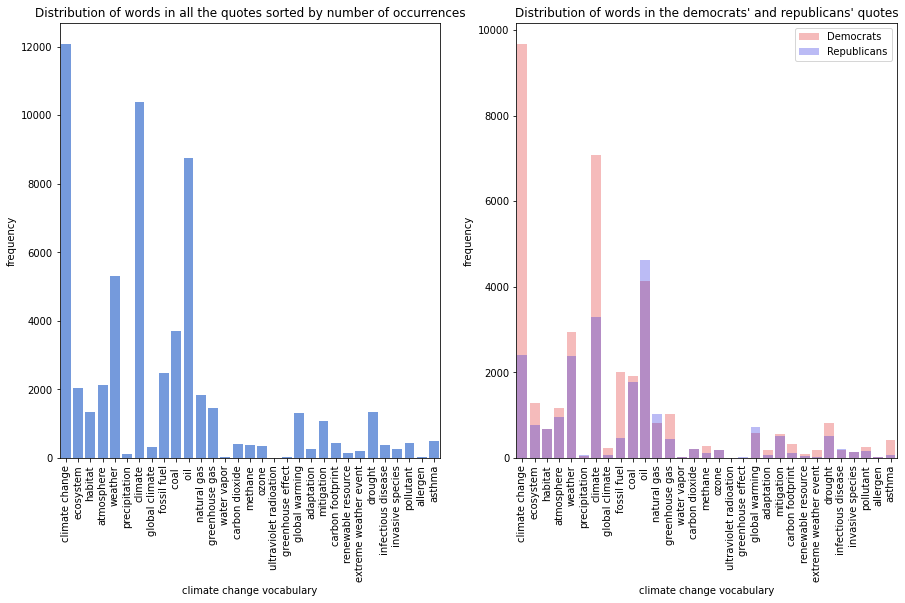

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

sns.barplot(data=df_climate_change_words, x = 'climate change vocabulary', y='count', label='tot', color='cornflowerblue', ax=ax[0], alpha=1)
sns.barplot(data=df_climate_change_words_dem, x = 'climate change vocabulary', y='count', label='Democrats', ax=ax[1], color='r', alpha=0.3)
sns.barplot(data=df_climate_change_words_rep, x = 'climate change vocabulary', y='count', label='Republicans', ax=ax[1], color='b', alpha=0.3)

ax[0].set_xticklabels(list_climate_change_words, rotation=90)
ax[1].set_xticklabels(list_climate_change_words, rotation=90)

ax[0].set_ylabel('frequency')
ax[1].set_ylabel('frequency')

ax[0].set_title('Distribution of words in all the quotes sorted by number of occurrences')
ax[1].set_title('Distribution of words in the democrats\' and republicans\' quotes')

plt.legend()

In [3]:
# Add number of quotations per qid to dataframe (Caution: this column is already aggregated)
df_climate_change['quotationCounts'] = df_climate_change.groupby(['qids'])['quoteID'].transform("count")
n_quotes_qid_df = df_climate_change.drop_duplicates(subset=['qids'])[['party', 'speaker', 'quotationCounts']].sort_values(by='quotationCounts', ascending=False)


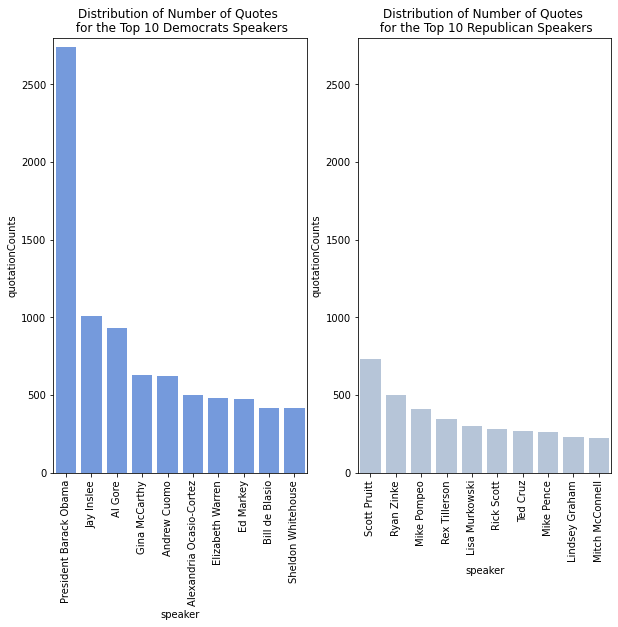

In [10]:
n_quotes_per_qid_demo = n_quotes_qid_df[n_quotes_qid_df['party']=='Q29552']
n_quotes_per_qid_rep = n_quotes_qid_df[n_quotes_qid_df['party']=='Q29468']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))
top_10_rep = n_quotes_per_qid_rep.head(10)['speaker']
top_10_demo = n_quotes_per_qid_demo.head(10)['speaker']
sns.barplot(data=n_quotes_per_qid_demo.head(10), x = 'speaker', y='quotationCounts', label='Democrats', color='cornflowerblue', ax=ax[0], alpha=1)
sns.barplot(data=n_quotes_per_qid_rep.head(10), x = 'speaker', y='quotationCounts', label='Republicans', color='lightsteelblue', ax=ax[1], alpha=1)

ax[0].set_xticklabels(top_10_demo, rotation=90)
ax[1].set_xticklabels(top_10_rep, rotation=90)

ax[0].set_title('Distribution of Number of Quotes \n for the Top 10 Democrats Speakers')
ax[1].set_title('Distribution of Number of Quotes \n for the Top 10 Republican Speakers')

ax[0].set_ylim(top=2800)
ax[1].set_ylim(top=2800)

plt.show()

In [11]:
# TODO: remove in the future
# It is just an example of how a word 'oil' can be not related to climate change
df_climate_change.loc[7681325, 'quotation']

"Our sense is that ISIL is taking its profits basically at the wellhead and, so, while you do have ISIL oil ending up in a variety of different places, that's not really the pressure we want when it comes to stemming the flow of funding -- it really comes down to taking down their infrastructure,"

# **NLP Methodologies**

## **Calculating quotes Similarities using different models**

In [13]:
!pip install --upgrade scipy

     |████████████████████████████████| 38.1 MB 1.5 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [4]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import re
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**tf idf method**

In [9]:
df_quotations = pd.DataFrame(df_climate_change['quotation'])

# removing special characters and stop words from the text
stop_words_l=stopwords.words('english')
#remove special characters, remove stop words, and convert everything to lower case
df_quotations['quotations_cleaned']=df_quotations.quotation.apply(lambda x: " ".join(re.sub(r'[^a-zA-Z]',' ',w).lower() for w in x.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words_l) )

df_quotations_demo = pd.DataFrame(df_climate_change[df_climate_change['party']=='Q29552']['quotation'])
df_quotations_demo['quotations_cleaned']=df_quotations_demo.quotation.apply(lambda x: " ".join(re.sub(r'[^a-zA-Z]',' ',w).lower() for w in x.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words_l) )
df_quotations_rep = pd.DataFrame(df_climate_change[df_climate_change['party']=='Q29468']['quotation'])
df_quotations_rep['quotations_cleaned']=df_quotations_rep.quotation.apply(lambda x: " ".join(re.sub(r'[^a-zA-Z]',' ',w).lower() for w in x.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words_l) )


In [15]:
tfidfvectoriser=TfidfVectorizer()

tfidf_vectors = tfidfvectoriser.fit(df_quotations.quotations_cleaned)


#pairwise_differences_euc = euclidean_distances(tfidf_vectors_demo.astype(np.float32))


In [ ]:
tfidf_vectors_demo = tfidfvectoriser.transform(df_quotations_demo.quotations_cleaned)
pairwise_differences_cos_demo = cosine_similarity(tfidf_vectors_demo.astype(np.float32))
print('pairwise_differences_cos_demo', pairwise_differences_cos_demo.shape)
print('pairwise_differences_cos_demo', pairwise_differences_cos_demo.mean())

pairwise_differences_cos_demo (35791, 35791)
pairwise_differences_cos_demo 0.012282015


In [ ]:
tfidf_vectors_rep = tfidfvectoriser.transform(df_quotations_rep.quotations_cleaned)
pairwise_differences_cos_rep = cosine_similarity(tfidf_vectors_rep.astype(np.float32))
print('pairwise_differences_cos_rep', pairwise_differences_cos_rep.shape)
print('pairwise_differences_cos_rep', pairwise_differences_cos_rep.mean())

pairwise_differences_cos_rep (21461, 21461)
pairwise_differences_cos_rep 0.010091701


In [ ]:
(tfidf_vectors_rep.shape, tfidf_vectors_demo.shape)

((21461, 29782), (35791, 29782))

In [ ]:
import random
random.seed(42)
randomlist = random.sample(range(0, tfidf_vectors_demo.shape[0]), tfidf_vectors_rep.shape[0])
small_demos = tfidf_vectors_demo[randomlist, :]


In [ ]:
pairwise_differences_cos_rep_demo = cosine_similarity(tfidf_vectors_rep.astype(np.float32), small_demos.astype(np.float32))
print('pairwise_differences_cos_rep_demo', pairwise_differences_cos_rep_demo.mean())

pairwise_differences_cos_rep_demo 0.010014706


**BERT**

In [6]:
!pip install sentence_transformers

     |████████████████████████████████| 78 kB 3.2 MB/s 
     |████████████████████████████████| 3.3 MB 24.2 MB/s 
     |████████████████████████████████| 3.3 MB 42.3 MB/s 
     |████████████████████████████████| 1.2 MB 41.1 MB/s 
     |████████████████████████████████| 61 kB 548 kB/s 
     |████████████████████████████████| 895 kB 42.5 MB/s 
     |████████████████████████████████| 596 kB 54.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=141c2897068c6743dbbd222a584aa7dffad43d087c1d6ba1ed97ae5f011f0fe9
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [7]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
from sklearn.metrics import pairwise_distances_chunked
from tqdm import tqdm

def reduce_func(D_chunk, start):
    #  neigh = [np.flatnonzero(d < r) for d in D_chunk]
     avg_dist = D_chunk.mean(axis=1)
     return avg_dist

# compute the similarity per chunks in order to be able to fit in the memory
def bert_cos_similarity(df1, df2 = None):
    document_embeddings1 = sbert_model.encode(list(df1['quotations_cleaned']), device='cuda').astype(np.float32)
    if df2 is None:
        document_embeddings2 = document_embeddings1
    else:
        document_embeddings2 = sbert_model.encode(list(df2['quotations_cleaned']), device='cuda').astype(np.float32)

    gen = pairwise_distances_chunked(document_embeddings1, document_embeddings2, reduce_func=reduce_func, metric='cosine')

    sum = 0
    i=1
    for avg_dist in tqdm(gen):
        sum += avg_dist.mean()
        mean = sum/i
        i+=1
        # print(f'{avg_dist} {len(avg_dist)}')
        # print(f"now the mean is:{mean}")
    # print(f"final mean:{mean}")
    return 1-mean




In [ ]:
# compute the average similarity between the republicans and the democrats
rep_dem_bert_cos_similarity = bert_cos_similarity(df_quotations_rep, df_quotations_demo)
rep_dem_bert_cos_similarity

6it [00:19,  3.30s/it]


0.45248291889826453

In [ ]:
# compute the average similarity within the democrats
dem_bert_cos_similarity = bert_cos_similarity(df_quotations_demo)
dem_bert_cos_similarity

10it [00:33,  3.30s/it]


0.4752903938293457

In [ ]:
# compute the average similarity within the republicans
rep_bert_cos_similarity = bert_cos_similarity(df_quotations_rep)
rep_bert_cos_similarity

4it [00:11,  2.96s/it]


0.4389721602201462

## Aggregating on person level

In [18]:
#number of words in every quotation
words_count = list(df_quotations['quotations_cleaned'].str.split().apply(len))

In [15]:
document_embeddings = sbert_model.encode(list(df_quotations['quotations_cleaned'])).astype(np.float32)

In [19]:
embeddings_df = pd.DataFrame(document_embeddings)
embeddings_df['words_count'] = words_count
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,words_count
0,0.392290,0.362596,1.506887,0.390396,-0.083792,-0.967880,0.010326,-0.028203,0.081313,-0.131849,-0.308205,1.036696,-0.198510,-0.064342,-0.690468,0.594308,-0.530895,-0.626859,-0.007865,-0.375110,0.071739,-0.984709,0.081912,-0.403449,0.864479,-0.335550,-0.322526,-0.506811,-0.792475,0.512030,-0.241799,0.529714,-0.557426,-0.234586,-1.225674,0.798766,1.636289,0.673517,0.095186,0.025802,...,-0.470464,0.118771,-0.184266,0.402645,0.265229,0.391441,0.344368,0.277599,-0.477138,-1.291873,-0.383138,0.360727,-0.278135,-0.551665,-0.213693,1.053849,0.278814,-0.203556,0.205369,0.239032,0.076757,0.324818,-0.538869,0.109057,0.458316,0.335299,0.523931,-0.801941,-0.095170,-0.064166,-0.744371,-0.278051,-1.473776,-0.341439,0.113761,-0.239045,-0.442193,-0.421148,0.430656,28
1,-0.276089,0.059983,0.748883,0.689667,0.430615,-0.071770,0.535857,-0.174377,0.370182,-0.041790,-0.099761,0.034364,-0.086719,0.684485,0.672396,0.017776,-1.381113,0.412645,0.144851,-0.101282,-0.009550,0.275093,-0.345103,-0.220950,0.630575,-0.443851,0.037435,-1.165506,-0.856562,0.292411,-0.442392,0.860950,-0.485955,-0.018936,0.057130,0.658449,-0.363748,-0.088727,-0.180143,0.427678,...,-0.815111,-0.297989,0.202722,-0.064484,0.778804,0.802075,0.525397,0.135450,0.272797,-0.524863,-0.735941,-0.859386,1.220451,-0.204889,0.454962,-0.058292,0.459017,-0.155039,0.173957,-0.623147,0.248971,0.990797,0.736442,0.729480,-0.583250,-0.022557,0.174625,-0.097271,-0.388408,0.236517,-0.108941,-0.092784,0.187574,-0.348918,-0.770271,-0.009357,-1.365222,-0.431023,0.104164,6
2,-0.262492,0.311869,0.160342,0.069163,0.690900,-0.646249,-0.016825,-0.438863,0.247877,-0.926257,0.474024,1.071200,0.139002,0.206347,-1.509502,0.279838,-0.434678,0.450750,-0.181156,0.089227,-0.295112,-0.499409,0.440355,1.611041,1.010058,0.196579,-0.016638,0.661965,-0.777819,0.274797,-0.017135,0.959826,-0.604777,-0.333916,-0.261854,1.271795,0.547384,-0.310361,-0.088402,0.233138,...,-0.339654,0.892052,-0.633574,0.522622,0.480226,-0.341362,0.408706,-0.275880,0.244384,-0.765245,-1.040962,-0.227464,0.504923,-0.082724,-0.133145,0.089076,0.587382,-0.538049,0.172374,0.573811,0.209099,0.388579,-1.488149,1.051013,0.774377,-0.086767,0.986590,-0.077343,0.280939,-0.520410,-0.945611,-0.691763,-0.954207,0.206712,-0.914305,-1.009511,-0.493819,-0.396181,-0.348898,26
3,-0.173631,0.262899,-0.454810,0.490647,0.535360,-0.734528,-0.146519,-0.121214,0.100566,0.168450,-0.207073,0.884184,0.579100,0.253797,-0.528084,0.449425,-0.095694,0.513449,0.253689,-0.216843,-0.738063,0.192891,0.146313,0.621648,0.545283,0.190566,-0.384007,-0.103311,-0.556065,0.595463,0.146289,0.767840,-0.731560,0.133493,0.823824,0.584931,-0.401407,0.131814,-0.228329,-0.396380,...,-0.796681,-0.261922,-0.142453,0.395227,0.194575,1.106904,1.033513,-0.307096,0.007026,-1.202947,-1.595917,-1.367590,0.989817,-0.431020,-0.022003,-0.004638,1.830119,-0.107874,-0.467260,-0.115369,0.415135,0.621610,-1.138309,1.161846,-0.607661,-0.233466,0.626053,0.157353,-0.005124,0.565139,0.128003,-0.577663,-0.596033,0.823745,-0.953657,0.015019,0.140466,-0.214267,0.039831,13
4,-0.232973,0.923275,0.312170,0.428204,0.195382,-1.031741,0.752052,0.171839,0.358599,-0.640962,0.067704,0.175315,0.267779,-0.072377,-0.552851,0.565083,0.168140,0.071761,0.217430,-0.031299,-0.494958,-0.557887,0.265033,0.187148,1.366925,0.123585,0.021434,-0.216149,-0.288605,0.211154,-0.173858,1.100585,-0.919371,-0.314065,-0.053473,1.246847,0.543307,0.480022,0.097977,-0.377781,...,-0.188017,-0.297765,-0.620104,-0.256765,0.125055,0.255995,0.554811,0.113820,0.138856,-0.900987,-0.938395,-0.542258,0.391879,-0.430982,0.051312,0.452928,-0.067167,-0.450576,0.246886,0.093080,0.401223,0.818779,0.487191,0.186521,0.541538,0.148725,1.061945,-0.012466,-0.015277,-0.145145,-0.498284,0.0

In [20]:
embeddings_df['embeddings']= embeddings_df[range(768)].values.tolist()

In [21]:
#embeddings_df = pd.DataFrame(embeddings_df['embeddings'])
embeddings_df['embeddings'] = embeddings_df['embeddings'].apply(lambda x: np.array(x))

In [22]:
df = embeddings_df.merge(right=df_climate_change.reset_index(), how='inner', left_index=True, right_index=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,words_count,embeddings,index,quoteID,quotation,speaker,qids,probas,gender,occupation,party,max_prob_speaker,max_probas,quotationCounts,climate_change_voc
0,0.392290,0.362596,1.506887,0.390396,-0.083792,-0.967880,0.010326,-0.028203,0.081313,-0.131849,-0.308205,1.036696,-0.198510,-0.064342,-0.690468,0.594308,-0.530895,-0.626859,-0.007865,-0.375110,0.071739,-0.984709,0.081912,-0.403449,0.864479,-0.335550,-0.322526,-0.506811,-0.792475,0.512030,-0.241799,0.529714,-0.557426,-0.234586,-1.225674,0.798766,1.636289,0.673517,0.095186,0.025802,...,-0.213693,1.053849,0.278814,-0.203556,0.205369,0.239032,0.076757,0.324818,-0.538869,0.109057,0.458316,0.335299,0.523931,-0.801941,-0.095170,-0.064166,-0.744371,-0.278051,-1.473776,-0.341439,0.113761,-0.239045,-0.442193,-0.421148,0.430656,28,"[0.3922901153564453, 0.36259564757347107, 1.50...",17,2020-01-05-025623,"Obviously, a message that some people responde...",Julián Castro,Q970720,"[[Julián Castro, 0.8279], [None, 0.1651], [Ber...",[Q6581097],"[Q82955, Q40348]",Q29552,Julián Castro,0.8279,92,[ecosystem]
1,-0.276089,0.059983,0.748883,0.689667,0.430615,-0.071770,0.535857,-0.174377,0.370182,-0.041790,-0.099761,0.034364,-0.086719,0.684485,0.672396,0.017776,-1.381113,0.412645,0.144851,-0.101282,-0.009550,0.275093,-0.345103,-0.220950,0.630575,-0.443851,0.037435,-1.165506,-0.856562,0.292411,-0.442392,0.860950,-0.485955,-0.018936,0.057130,0.658449,-0.363748,-0.088727,-0.180143,0.427678,...,0.454962,-0.058292,0.459017,-0.155039,0.173957,-0.623147,0.248971,0.990797,0.736442,0.729480,-0.583250,-0.022557,0.174625,-0.097271,-0.388408,0.236517,-0.108941,-0.092784,0.187574,-0.348918,-0.770271,-0.009357,-1.365222,-0.431023,0.104164,6,"[-0.2760894298553467, 0.05998332425951958, 0.7...",38,2020-03-27-028836,is poised to reverse course on state climate p...,Gavin Newsom,Q461391,"[[Gavin Newsom, 0.7522], [None, 0.2478]]",[Q6581097],"[Q82955, Q3427922, Q43845]",Q29552,Gavin Newsom,0.7522,313,[climate]
2,-0.262492,0.311869,0.160342,0.069163,0.690900,-0.646249,-0.016825,-0.438863,0.247877,-0.926257,0.474024,1.071200,0.139002,0.206347,-1.509502,0.279838,-0.434678,0.450750,-0.181156,0.089227,-0.295112,-0.499409,0.440355,1.611041,1.010058,0.196579,-0.016638,0.661965,-0.777819,0.274797,-0.017135,0.959826,-0.604777,-0.333916,-0.261854,1.271795,0.547384,-0.310361,-0.088402,0.233138,...,-0.133145,0.089076,0.587382,-0.538049,0.172374,0.573811,0.209099,0.388579,-1.488149,1.051013,0.774377,-0.086767,0.986590,-0.077343,0.280939,-0.520410,-0.945611,-0.691763,-0.954207,0.206712,-0.914305,-1.009511,-0.493819,-0.396181,-0.348898,26,"[-0.26249176263809204, 0.31186896562576294, 0....",142,2020-02-03-092855,"We discussed ways, too, to further improve the...",Mike Pompeo,Q473239,"[[Mike Pompeo, 0.8043], [None, 0.1655], [Abdul...",[Q6581097],"[Q40348, Q43845, Q2961975, Q189290, Q82955]",Q29468,Mike Pompeo,0.8043,411,[climate]
3,-0.173631,0.262899,-0.454810,0.490647,0.535360,-0.734528,-0.146519,-0.121214,0.100566,0.168450,-0.207073,0.884184,0.579100,0.253797,-0.528084,0.449425,-0.095694,0.513449,0.253689,-0.216843,-0.738063,0.192891,0.146313,0.621648,0.545283,0.190566,-0.384007,-0.103311,-0.556065,0.595463,0.146289,0.767840,-0.731560,0.133493,0.823824,0.584931,-0.401407,0.131814,-0.228329,-0.396380,...,-0.022003,-0.004638,1.830119,-0.107874,-0.467260,-0.115369,0.415135,0.621610,-1.138309,1.161846,-0.607661,-0.233466,0.626053,0.157353,-0.005124,0.565139,0.128003,-0.577663,-0.596033,0.823745,-0.953657,0.015019,0.140466,-0.214267,0.039831,13,"[-0.17363065481185913, 0.26289939880371094, -0...",157,2020-02-18-014398,cutting off (Venezuelan President Nicolas) Mad...,Mike Pompeo,Q473239,"[[Mike Pompeo, 0.711], [Jorge Arreaza, 0.2204]...",[Q6581097],"[Q40348, Q43845, Q2961975, Q189290, Q82955]",Q29468,Mike Pompeo,0.7110,411,[ oil ]

In [23]:
speaker_embeddings = pd.DataFrame(df.groupby(by=['qids']).mean())
speaker_embeddings

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,words_count,index,max_probas,quotationCounts
qids,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Q1026119,-0.536326,0.394520,0.228848,0.167920,0.174588,-1.035974,-0.284449,0.484130,0.439821,-0.690659,0.155084,0.480205,0.388771,0.442856,-0.203715,0.446224,-0.385430,-0.111054,0.183865,-0.336238,-0.164392,-0.680998,0.730367,0.290025,1.138237,0.012076,-0.479029,-0.276269,-0.720881,0.061013,-0.443775,0.789852,-0.570844,-0.368051,-0.086192,1.346207,-0.106367,-0.184372,0.015998,-0.430114,...,-0.634840,0.287954,0.567875,0.408779,0.527659,-0.162379,-0.809090,-0.444717,-0.735685,0.085757,-0.419947,-0.286361,-0.327894,0.313055,-0.286735,0.178258,-0.257379,0.034853,0.512240,-0.905915,0.449981,0.419267,-0.100765,0.621482,0.179663,0.245936,0.063172,-0.508997,-0.590401,-0.775920,-0.183768,-0.811389,-0.129250,-0.655885,0.075738,-0.289588,18.500000,2.884552e+06,0.867600,4.0
Q1027431,-0.089951,0.556979,0.682544,0.372893,0.084241,-0.986536,-0.091771,-0.012543,0.410426,-0.325710,0.363067,0.762879,-0.072394,0.644393,-0.148450,0.278713,-0.769639,0.103071,-0.101884,-0.224234,0.203638,-0.324782,0.323207,0.293593,1.066811,-0.250561,-0.250730,-0.219840,-0.468610,0.436396,-0.259894,1.146304,-0.756857,-0.026583,-0.319898,1.010159,0.095333,-0.288382,0.073383,0.024981,...,0.084151,0.337282,0.696177,0.318428,0.472703,0.051462,-0.729813,-0.853303,-1.189901,0.094307,-0.116062,0.143356,0.143192,0.152191,-0.387910,0.404942,0.045473,0.434969,0.713168,-0.167583,0.542703,0.200222,0.397596,0.529756,-0.076164,0.099814,-0.047867,-0.138626,-0.312746,-0.562049,-0.349972,-0.964541,0.048990,-0.778958,-0.015705,-0.068027,13.750000,4.809882e+06,0.818638,8.0
Q1029527,0.092411,0.529833,0.566304,0.176370,0.132939,-0.689673,0.275030,0.293705,0.245521,-0.443756,0.037315,0.551603,0.220330,0.390904,-0.333933,0.392252,-0.304860,-0.167685,0.064981,-0.232717,-0.093528,-0.285050,0.429607,0.055496,0.802852,-0.129811,-0.312441,-0.648497,-0.848009,0.433813,-0.148339,0.769624,-0.822453,-0.034260,-0.056678,1.109627,0.104464,0.049776,-0.013674,-0.371102,...,-0.185251,-0.014267,0.637945,0.819614,0.184619,-0.093535,-0.841894,-0.826961,-0.556561,0.028017,-0.375134,-0.198182,0.145947,0.251523,-0.002737,0.340454,0.274044,0.325237,0.757267,-0.172480,0.587076,0.123403,0.029546,0.169511,-0.311977,0.124282,0.075865,-0.286628,-0.345726,-1.023969,-0.079081,-0.767494,-0.118257,-0.394877,-0.432880,0.023874,25.333333,5.338808e+06,0.855367,6.0
Q10327963,0.095503,0.576752,0.626347,0.235384,0.558319,-0.610930,0.424729,0.318689,0.556911,-0.491795,-0.158293,0.404900,0.244128,0.416012,-0.492439,0.248028,-0.201241,0.161512,0.279145,-0.225563,-0.192484,-0.336702,0.525626,0.062600,0.973552,0.142698,-0.398768,0.167117,-0.921007,0.425556,-0.499984,0.907745,-0.845935,0.112464,-0.268309,0.975624,-0.097192,-0.294474,-0.021193,-0.043568,...,-0.187032,0.094840,0.601061,0.365004,0.137652,-0.044632,-0.714557,-0.879512,-0.808588,0.525344,-0.250431,-0.374672,-0.027769,0.347888,-0.119625,-0.049526,0.060477,0.543775,0.594494,0.066719,0.644158,0.282526,0.295031,0.265424,-0.506831,0.039186,-0.105165,-0.391081,-0.450106,-0.658927,-0.228000,-1.156686,0.245468,-0.663404,-0.357643,0.271293,21.500000,3.058824e+06,0.797450,10.0
Q10346298,0.095910,0.457592,1.307174,0.432602,-0.127292,-0.551397,0.547214,-0.355029,0.238458,-0.556687,0.066706,0.505383,0.044131,0.172691,-0.499400,0.229404,-0.276939,-0.341918,0.232673,-0.312125,-0.230299,-0.469342,0.251407,0.025714,0.668187,0.235614,-0.290329,0.282209,-0.915859,0.384677,-0.256227,0.938871,-0.083025,-0.201978,0.203623,0.522794,0.554638,0.182023,0.322865,0.152983,...,0.128357,-0.219236,0.069907,0.334807,0.366730,-0.314247,-0.610711,-1.046659,-0.674125,0.270251,-0.341368,-0.011059,0.381916,0.261763,0.364

In [24]:
speaker_embeddings = speaker_embeddings.merge(right=df_climate_change[['speaker', 'party', 'qids']], how='inner', left_index=True, right_on='qids').drop_duplicates(subset=['qids'])
speaker_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,words_count,index,max_probas,quotationCounts,speaker,party,qids
1040594,-0.536326,0.394520,0.228848,0.167920,0.174588,-1.035974,-0.284449,0.484130,0.439821,-0.690659,0.155084,0.480205,0.388771,0.442856,-0.203715,0.446224,-0.385430,-0.111054,0.183865,-0.336238,-0.164392,-0.680998,0.730367,0.290025,1.138237,0.012076,-0.479029,-0.276269,-0.720881,0.061013,-0.443775,0.789852,-0.570844,-0.368051,-0.086192,1.346207,-0.106367,-0.184372,0.015998,-0.430114,...,0.408779,0.527659,-0.162379,-0.809090,-0.444717,-0.735685,0.085757,-0.419947,-0.286361,-0.327894,0.313055,-0.286735,0.178258,-0.257379,0.034853,0.512240,-0.905915,0.449981,0.419267,-0.100765,0.621482,0.179663,0.245936,0.063172,-0.508997,-0.590401,-0.775920,-0.183768,-0.811389,-0.129250,-0.655885,0.075738,-0.289588,18.500000,2884551.75,0.867600,4.0,Cal Dooley,Q29552,Q1026119
1290135,-0.089951,0.556979,0.682544,0.372893,0.084241,-0.986536,-0.091771,-0.012543,0.410426,-0.325710,0.363067,0.762879,-0.072394,0.644393,-0.148450,0.278713,-0.769639,0.103071,-0.101884,-0.224234,0.203638,-0.324782,0.323207,0.293593,1.066811,-0.250561,-0.250730,-0.219840,-0.468610,0.436396,-0.259894,1.146304,-0.756857,-0.026583,-0.319898,1.010159,0.095333,-0.288382,0.073383,0.024981,...,0.318428,0.472703,0.051462,-0.729813,-0.853303,-1.189901,0.094307,-0.116062,0.143356,0.143192,0.152191,-0.387910,0.404942,0.045473,0.434969,0.713168,-0.167583,0.542703,0.200222,0.397596,0.529756,-0.076164,0.099814,-0.047867,-0.138626,-0.312746,-0.562049,-0.349972,-0.964541,0.048990,-0.778958,-0.015705,-0.068027,13.750000,4809882.50,0.818638,8.0,Tim Wirth,Q29552,Q1027431
1315818,0.092411,0.529833,0.566304,0.176370,0.132939,-0.689673,0.275030,0.293705,0.245521,-0.443756,0.037315,0.551603,0.220330,0.390904,-0.333933,0.392252,-0.304860,-0.167685,0.064981,-0.232717,-0.093528,-0.285050,0.429607,0.055496,0.802852,-0.129811,-0.312441,-0.648497,-0.848009,0.433813,-0.148339,0.769624,-0.822453,-0.034260,-0.056678,1.109627,0.104464,0.049776,-0.013674,-0.371102,...,0.819614,0.184619,-0.093535,-0.841894,-0.826961,-0.556561,0.028017,-0.375134,-0.198182,0.145947,0.251523,-0.002737,0.340454,0.274044,0.325237,0.757267,-0.172480,0.587076,0.123403,0.029546,0.169511,-0.311977,0.124282,0.075865,-0.286628,-0.345726,-1.023969,-0.079081,-0.767494,-0.118257,-0.394877,-0.432880,0.023874,25.333333,5338807.50,0.855367,6.0,Steve Womack,Q29468,Q1029527
32330,0.095503,0.576752,0.626347,0.235384,0.558319,-0.610930,0.424729,0.318689,0.556911,-0.491795,-0.158293,0.404900,0.244128,0.416012,-0.492439,0.248028,-0.201241,0.161512,0.279145,-0.225563,-0.192484,-0.336702,0.525626,0.062600,0.973552,0.142698,-0.398768,0.167117,-0.921007,0.425556,-0.499984,0.907745,-0.845935,0.112464,-0.268309,0.975624,-0.097192,-0.294474,-0.021193,-0.043568,...,0.365004,0.137652,-0.044632,-0.714557,-0.879512,-0.808588,0.525344,-0.250431,-0.374672,-0.027769,0.347888,-0.119625,-0.049526,0.060477,0.543775,0.594494,0.066719,0.644158,0.282526,0.295031,0.265424,-0.506831,0.039186,-0.105165,-0.391081,-0.450106,-0.658927,-0.228000,-1.156686,0.245468,-0.663404,-0.357643,0.271293,21.500000,3058823.50,0.797450,10.0,Mead Treadwell,Q29468,Q10327963
655115,0.095910,0.457592,1.307174,0.432602,-0.127292,-0.551397,0.547214,-0.355029,0.238458,-0.556687,0.066706,0.505383,0.044131,0.172691,-0.499400,0.229404,-0.276939,-0.341918,0.232673,-0.312125,-0.230299,-0.469342,0.251407,0.025714,0.668187,0.235614,-0.290329,0.282209,-0.915859,0.384677,-0.256227,0.938871,-0.083025,-0.201978,0.203623,0.522794,0.554638,0.182023,0.322865,0.152983,...,0.334807,0.366730,-0.314247,-0.610711,-1.046659,-0.674125,0.270251,-0.341368,-0.011059,0.381916,0.261763,0.364463,0.482853,0.175077,0.083998,0.671945,-0.329927,0.082321,0.478577,0.203737,0.372819,-0.681629,0.091651,-0.543477,-0.69102

In [25]:
pd.DataFrame(speaker_embeddings.reset_index(inplace=True))
speaker_embeddings.drop(columns='level_0', inplace=True)

In [26]:
#similarity matrix aggregated on person level: shape: n_speakers x n_speakers
speaker_similarity_matrix = cosine_similarity(speaker_embeddings[range(768)])

In [27]:
# similarity matrix between each speaker and the democrats
demo_indices = speaker_embeddings.loc[(speaker_embeddings.party == 'Q29552')].index
rep_indices = speaker_embeddings.loc[(speaker_embeddings.party == 'Q29468')].index

In [28]:
# similarity between each speaker and all the democrats 
similarity_with_democrats = speaker_similarity_matrix[:, demo_indices].mean(axis=1)
# similarity between each speaker and all the republicans
similarity_with_republicans = speaker_similarity_matrix[:, rep_indices].mean(axis=1)

In [29]:
# join these two columns to the speaker_embeddings dataframe
speaker_embeddings['similarity_with_democrats'] = similarity_with_democrats
speaker_embeddings['similarity_with_republicans'] = similarity_with_republicans

In [30]:
speaker_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,words_count,index,max_probas,quotationCounts,speaker,party,qids,similarity_with_democrats,similarity_with_republicans
0,-0.536326,0.394520,0.228848,0.167920,0.174588,-1.035974,-0.284449,0.484130,0.439821,-0.690659,0.155084,0.480205,0.388771,0.442856,-0.203715,0.446224,-0.385430,-0.111054,0.183865,-0.336238,-0.164392,-0.680998,0.730367,0.290025,1.138237,0.012076,-0.479029,-0.276269,-0.720881,0.061013,-0.443775,0.789852,-0.570844,-0.368051,-0.086192,1.346207,-0.106367,-0.184372,0.015998,-0.430114,...,-0.162379,-0.809090,-0.444717,-0.735685,0.085757,-0.419947,-0.286361,-0.327894,0.313055,-0.286735,0.178258,-0.257379,0.034853,0.512240,-0.905915,0.449981,0.419267,-0.100765,0.621482,0.179663,0.245936,0.063172,-0.508997,-0.590401,-0.775920,-0.183768,-0.811389,-0.129250,-0.655885,0.075738,-0.289588,18.500000,2884551.75,0.867600,4.0,Cal Dooley,Q29552,Q1026119,0.629021,0.621979
1,-0.089951,0.556979,0.682544,0.372893,0.084241,-0.986536,-0.091771,-0.012543,0.410426,-0.325710,0.363067,0.762879,-0.072394,0.644393,-0.148450,0.278713,-0.769639,0.103071,-0.101884,-0.224234,0.203638,-0.324782,0.323207,0.293593,1.066811,-0.250561,-0.250730,-0.219840,-0.468610,0.436396,-0.259894,1.146304,-0.756857,-0.026583,-0.319898,1.010159,0.095333,-0.288382,0.073383,0.024981,...,0.051462,-0.729813,-0.853303,-1.189901,0.094307,-0.116062,0.143356,0.143192,0.152191,-0.387910,0.404942,0.045473,0.434969,0.713168,-0.167583,0.542703,0.200222,0.397596,0.529756,-0.076164,0.099814,-0.047867,-0.138626,-0.312746,-0.562049,-0.349972,-0.964541,0.048990,-0.778958,-0.015705,-0.068027,13.750000,4809882.50,0.818638,8.0,Tim Wirth,Q29552,Q1027431,0.647183,0.618419
2,0.092411,0.529833,0.566304,0.176370,0.132939,-0.689673,0.275030,0.293705,0.245521,-0.443756,0.037315,0.551603,0.220330,0.390904,-0.333933,0.392252,-0.304860,-0.167685,0.064981,-0.232717,-0.093528,-0.285050,0.429607,0.055496,0.802852,-0.129811,-0.312441,-0.648497,-0.848009,0.433813,-0.148339,0.769624,-0.822453,-0.034260,-0.056678,1.109627,0.104464,0.049776,-0.013674,-0.371102,...,-0.093535,-0.841894,-0.826961,-0.556561,0.028017,-0.375134,-0.198182,0.145947,0.251523,-0.002737,0.340454,0.274044,0.325237,0.757267,-0.172480,0.587076,0.123403,0.029546,0.169511,-0.311977,0.124282,0.075865,-0.286628,-0.345726,-1.023969,-0.079081,-0.767494,-0.118257,-0.394877,-0.432880,0.023874,25.333333,5338807.50,0.855367,6.0,Steve Womack,Q29468,Q1029527,0.695938,0.679808
3,0.095503,0.576752,0.626347,0.235384,0.558319,-0.610930,0.424729,0.318689,0.556911,-0.491795,-0.158293,0.404900,0.244128,0.416012,-0.492439,0.248028,-0.201241,0.161512,0.279145,-0.225563,-0.192484,-0.336702,0.525626,0.062600,0.973552,0.142698,-0.398768,0.167117,-0.921007,0.425556,-0.499984,0.907745,-0.845935,0.112464,-0.268309,0.975624,-0.097192,-0.294474,-0.021193,-0.043568,...,-0.044632,-0.714557,-0.879512,-0.808588,0.525344,-0.250431,-0.374672,-0.027769,0.347888,-0.119625,-0.049526,0.060477,0.543775,0.594494,0.066719,0.644158,0.282526,0.295031,0.265424,-0.506831,0.039186,-0.105165,-0.391081,-0.450106,-0.658927,-0.228000,-1.156686,0.245468,-0.663404,-0.357643,0.271293,21.500000,3058823.50,0.797450,10.0,Mead Treadwell,Q29468,Q10327963,0.668713,0.652367
4,0.095910,0.457592,1.307174,0.432602,-0.127292,-0.551397,0.547214,-0.355029,0.238458,-0.556687,0.066706,0.505383,0.044131,0.172691,-0.499400,0.229404,-0.276939,-0.341918,0.232673,-0.312125,-0.230299,-0.469342,0.251407,0.025714,0.668187,0.235614,-0.290329,0.282209,-0.915859,0.384677,-0.256227,0.938871,-0.083025,-0.201978,0.203623,0.522794,0.554638,0.182023,0.322865,0.152983,...,-0.314247,-0.610711,-1.046659,-0.674125,0.270251,-0.341368,-0.011059,0.381916,0.261763,0.364463,0.482853,0.175077,0.083998,0.671945,-0.329927,0.082321,0.478577,0.203737,0.372819,-0.681629,0.091651,-0.543477,-0.6910

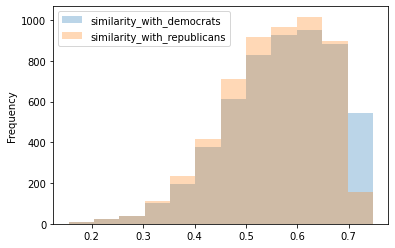

In [31]:
#plot distribution of similarity_with_democrats and similarity_with_republicans
speaker_embeddings[['similarity_with_democrats', 'similarity_with_republicans']].plot.hist(bins=12, alpha=0.3)

In [32]:
# let's see who are the people that have over 70% similarity with republicans and democrats
reps_similar_to_demos = speaker_embeddings[(speaker_embeddings['similarity_with_democrats'] > 0.7) & (speaker_embeddings['party']=='Q29468')][['similarity_with_democrats','qids', 'speaker', 'party', 'quotationCounts']]
demos_similar_to_demos = speaker_embeddings[(speaker_embeddings['similarity_with_democrats'] > 0.7) & (speaker_embeddings['party']!='Q29468')][['similarity_with_democrats','qids', 'speaker', 'party', 'quotationCounts']]


reps_similar_to_reps = speaker_embeddings[(speaker_embeddings['similarity_with_republicans'] > 0.7) & (speaker_embeddings['party']=='Q29468')][['similarity_with_republicans','qids', 'speaker', 'party', 'quotationCounts']]
demos_similar_to_reps = speaker_embeddings[(speaker_embeddings['similarity_with_republicans'] > 0.7) & (speaker_embeddings['party']!='Q29468')][['similarity_with_republicans','qids', 'speaker', 'party', 'quotationCounts']]


Text(0.5, 1.0, 'Distribution of Similarity Values of \n most Similar Politicians to Republicans')

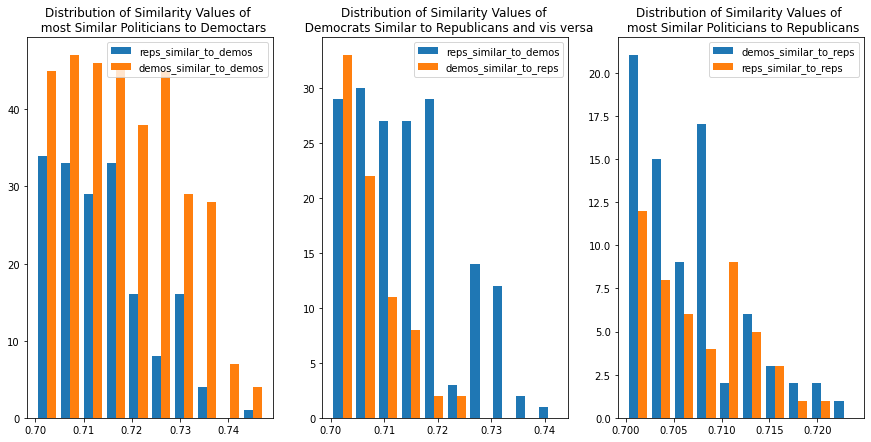

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))
list_of_columns = [np.array(reps_similar_to_demos['similarity_with_democrats']), np.array(demos_similar_to_demos['similarity_with_democrats'] )]
axs[0].hist(list_of_columns, label = ['reps_similar_to_demos', 'demos_similar_to_demos'])
axs[0].legend()
axs[0].set_title('Distribution of Similarity Values of \n  most Similar Politicians to Democtars')

list_of_columns = [np.array(reps_similar_to_demos['similarity_with_democrats']), np.array(demos_similar_to_reps['similarity_with_republicans'] )]
axs[1].hist(list_of_columns, label = ['reps_similar_to_demos', 'demos_similar_to_reps'])
axs[1].legend()
axs[1].set_title('Distribution of Similarity Values of \n  Democrats Similar to Republicans and vis versa')

list_of_columns = [np.array(demos_similar_to_reps['similarity_with_republicans']), np.array(reps_similar_to_reps['similarity_with_republicans'] )]
axs[2].hist(list_of_columns, label = ['demos_similar_to_reps', 'reps_similar_to_reps'])
axs[2].legend()
axs[2].set_title('Distribution of Similarity Values of \n most Similar Politicians to Republicans')


# Check correlation between number of words and Similarity 

Bootstrapping fills the memory!!!

In [ ]:
from scipy.stats import bootstrap
rng = np.random.default_rng()
res = bootstrap((df_quotations_demo, df_quotations_demo), bert_cos_similarity, vectorized=False, paired=True,method='percentile', random_state=rng)
print(res.confidence_interval)

In [ ]:
df_quotations_demo.dtypes

quotation             object
quotations_cleaned    object
dtype: object

## **Topic Detection**

In [16]:
# NOTE: Topic Detection might be more useful to use on all quotes to find other interesting topics such as climate change
# Transform quotes to list
climate_changes_quotes = df_climate_change['quotation'].tolist()
climate_change_quotes_dem = df_climate_change[df_climate_change['party']=='Q29552']['quotation'].tolist()
climate_change_quotes_rep = df_climate_change[df_climate_change['party']=='Q29468']['quotation'].tolist()

In [17]:
nlp = spacy.load('en')

STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

processed_quotes = list()

# Do the pipeline for quotes by Democrats
for quote in nlp.pipe(climate_change_quotes_dem, n_threads=5, batch_size=10):

    # Process document using Spacy NLP pipeline.
    ents = quote.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    quote = [token.lemma_ for token in quote if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    quote = [token for token in quote if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than word.
    quote.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_quotes.append(quote)
climate_change_quotes_dem = processed_quotes
del processed_quotes

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: Sele

In [18]:
# Add bigrams too
from gensim.models.phrases import Phrases

# Add bigrams to quotes (only ones that appear 15 times or more).
bigram = Phrases(climate_change_quotes_dem, min_count=15)

for idx in range(len(climate_change_quotes_dem)):
    for token in bigram[climate_change_quotes_dem[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            climate_change_quotes_dem[idx].append(token)

In [19]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(climate_change_quotes_dem)

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(quote) for quote in climate_change_quotes_dem]
# MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(corpus))

Number of unique tokens: 8167
Number of chunks: 35791


In [20]:
# Models
from gensim.models import LdaMulticore
params = {'passes': 10, 'random_state': seed}
base_models = dict()
model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6,
                passes=params['passes'], random_state=params['random_state'])

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [21]:
model.show_topic(1,20)

[('climate', 0.06495684),
 ('change', 0.04831299),
 ('climate_change', 0.043356713),
 ('think', 0.010458426),
 ('people', 0.010312277),
 ('issue', 0.008132417),
 ('know', 0.0068965433),
 ('world', 0.0065764673),
 ('global', 0.0064074425),
 ('come', 0.006034373),
 ('like', 0.005913634),
 ('thing', 0.00558282),
 ('right', 0.0053323573),
 ('time', 0.0052455566),
 ('want', 0.005122252),
 ('real', 0.0050819917),
 ('year', 0.004848215),
 ('need', 0.0047712107),
 ('science', 0.004747436),
 ('atmosphere', 0.004597012)]

In [22]:
# Plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

## **Semantic Analysis Based on Lexical Categories**

In [ ]:
lexicon = Empath()

# 194 different categories
print(str(len(list(lexicon.cats.keys()))) + " different categories")

# List the categories
print("\nExamples of these categories: ")
for cat in list(lexicon.cats.keys())[:10]:
    print(cat)

empath_cats = ["help", "nervousness", "horror", "optimism", "fear", "science", "sadness", "anger", "disappointment", "negative_emotion", "positive_emotion"]

In [ ]:
empath_features_dem = lexicon.analyze(climate_change_quotes_dem, categories = empath_cats, normalize = True)
empath_features_rep = lexicon.analyze(climate_change_quotes_rep, categories = empath_cats, normalize = True)

In [ ]:
empath_features_dem

In [ ]:
empath_features_rep

In [ ]:
# Create new lexical category that can be used to compare subgroups against
# e.g., here climate change
lexicon.create_category("climate_change", ["climate_change"], model="nytimes")

# **[DRAFT] Framework to Handle the Quotes for Next Milestone**

In [ ]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
from nltk.corpus import stopwords
import math
from collections import Counter
import numpy as np
nltk.download('stopwords')
nltk.download('punkt')

stemmer = PorterStemmer()

# Tokenize, stem a document
def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return " ".join([stemmer.stem(word.lower()) for word in tokens])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
content = df['quotation'] # Quotations
original_documents = [x.strip() for x in content] 
documents = [tokenize(d).split() for d in original_documents]
docs_n_doc_ids = list(zip(range(len(documents)), documents))


In [ ]:
# Create the vocabulary
vocabulary = set([item for sublist in documents for item in sublist])
vocabulary = [word for word in vocabulary if word not in stopwords.words('english')]
vocabulary.sort()

In [ ]:
# Compute IDF, storing idf values in a dictionary
def idf_values(vocabulary, documents):
    idf = {}
    num_documents = len(documents)
    for i, term in enumerate(vocabulary):
        idf[term] = math.log(num_documents/sum(term in document for document in documents), math.e)
    return idf

# Function to generate the vector for a document (with normalisation)
def vectorize(document, vocabulary, idf):
    vector = [0]*len(vocabulary)
    counts = Counter(document)
    max_count = counts.most_common(1)[0][1]
    for i,term in enumerate(vocabulary):
        vector[i] = idf[term] * counts[term]/max_count
    return vector

# Function to compute cosine similarity
def cosine_similarity(v1,v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    if sumxy == 0:
            result = 0
    else:
            result = sumxy/math.sqrt(sumxx*sumyy)
    return result

def vectorize_query(query, vocabulary, idf):
    q = query.split()
    q = [stemmer.stem(w) for w in q]
    query_vector = vectorize(q, vocabulary, idf)
    return query_vector
    
def search_vec(query, k):
    query_vector = vectorize_query(query, vocabulary, idf)
    scores = [[cosine_similarity(query_vector, document_vectors[d]), d] for d in range(len(documents))]
    scores.sort(key=lambda x: -x[0])
    ans = []
    indices = []
    for i in range(min(k,len(original_documents))):
        ans.append(original_documents[scores[i][1]])
        indices.append(scores[i][1])
    return ans, indices, query_vector

# Compute IDF values and vectors
idf = idf_values(vocabulary, documents)
document_vectors = [vectorize(s, vocabulary, idf) for s in documents]

In [ ]:
import operator

doc_vecs = np.transpose(np.array(document_vectors))
h = {}
for i, term in enumerate(vocabulary):
    ha = {}
    for docj in range(len(original_documents)):
        tfidf = doc_vecs[i][docj]
        ha[docj] = tfidf
    sorted_ha = sorted(ha.items(), key=operator.itemgetter(1), reverse=True)
    h[term] = sorted_ha